In [2]:
import sys
print(sys.executable)

/Users/michaelgathara/Documents/Projects/GPT/.venv/bin/python


In [3]:
import sys
import os
import json

# Get the parent directory of the current notebook
base_folder = os.path.abspath("..")
print(f"Your base folder is: {base_folder}")
sys.path.append(base_folder)

Your base folder is: /Users/michaelgathara/Documents/Projects/GPT


In [18]:
# PyTorch Stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available else "cpu")

# Library imports
import multiprocessing
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from data import get_wikitext_data, get_fineweb_data, save_data, load_data, clean_textdata
from tokenization import get_tiktoken_tokenizer


print(f"Using device: {device}")

Using device: mps


In [5]:
batch_size = 64  # Kept the same; could be adjusted based on hardware
block_size = 1024  # GPT-2 uses a context length of 1024 tokens
max_iters = 50000  # More iterations needed for larger models
eval_interval = 1000  # Increase since more iterations are done
learning_rate = 5e-5  # GPT-2 uses a lower learning rate
eval_iters = 500  # More frequent evaluation for stability

n_embd = 768  # GPT-2 uses 768 for the small version, 1024 for medium, 1280 for large, 1600 for XL
n_head = 12  # GPT-2 uses 12 attention heads
n_layer = 12  # GPT-2 has 12 transformer blocks in the small version
dropout = 0.1  # GPT-2 uses 0.1 dropout for better generalization

In [6]:
DATA_PATH = f"{base_folder}/data/tiktoken_tokenized_wikitext"
num_cores = multiprocessing.cpu_count()

tokenizer = get_tiktoken_tokenizer()
dataset = get_wikitext_data()
# save_data(dataset, DATA_PATH)

print(tokenizer)
print(dataset)

/Users/michaelgathara/Documents/Projects/GPT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Encoding 'gpt2'>
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


# Cleaning Data

In [7]:
def clean_batch(examples):
    cleaned_texts = [clean_textdata(text) for text in examples["text"]]
    cleaned_texts = list(filter(None, cleaned_texts))
    return {"text": cleaned_texts}

# Clean the entire dataset
cleaned_dataset = dataset.map(
    clean_batch,
    batched=True,
    batch_size=1000,
    num_proc=num_cores,
    desc="Cleaning text"
)

dataset["train"][0]["text"][:100]
cleaned_dataset["train"][0]["text"][:100]

print(cleaned_dataset)


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 2891
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1165029
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2461
    })
})


Min length: 1
Max length: 1446
Average length: 96.00
Median length: 82.00
90th percentile: 220
95th percentile: 264
99th percentile: 976
Number of sequences: 1165029


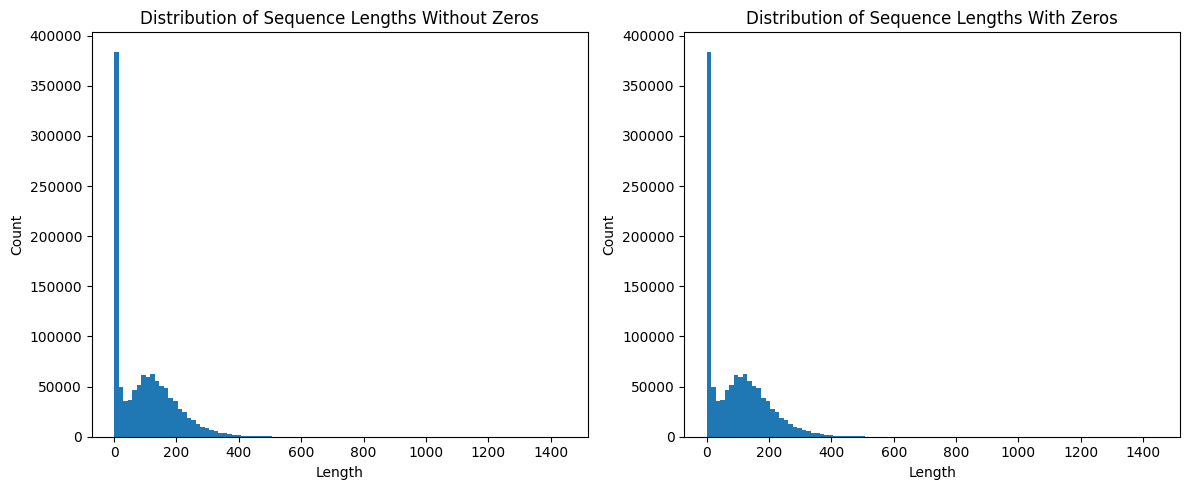

In [20]:
# print(cleaned_dataset["test"]["text"])
import numpy as np

def analyze_lengths(examples, tokenizer):
    tokens = [tokenizer.encode(text) for text in examples["text"]]
    return {"lengths": [len(token) for token in tokens]}

length_dataset = cleaned_dataset.map(
    analyze_lengths,
    fn_kwargs={"tokenizer": tokenizer},
    batched=True,
    batch_size=1000,
    num_proc=num_cores,
    desc="Analyzing sequence lengths"
)

max_lengths_zeros = [item for item in length_dataset["train"]["lengths"]]
max_lengths_non_zeros = [item for item in length_dataset["train"]["lengths"] if item not in [0]]

lengths_array = np.array(max_lengths_non_zeros)
lengths_array_zeros = np.array(max_lengths_zeros)
print(f"Min length: {np.min(lengths_array)}")
print(f"Max length: {np.max(lengths_array)}")
print(f"Average length: {np.mean(lengths_array):.2f}")
print(f"Median length: {np.median(lengths_array):.2f}")
print(f"90th percentile: {np.percentile(lengths_array, 90):.0f}")
print(f"95th percentile: {np.percentile(lengths_array, 95):.0f}")
print(f"99th percentile: {np.percentile(lengths_array, 99.9995):.0f}")
print(f"Number of sequences: {len(lengths_array)}")

bin_size = 100
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(lengths_array, bins=bin_size)
axs[0].set_title('Distribution of Sequence Lengths Without Zeros')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Count')

axs[1].hist(lengths_array_zeros, bins=bin_size)
axs[1].set_title('Distribution of Sequence Lengths With Zeros')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
# def tokenize_batch_old(examples, tokenizer, max_length=1024):
#     tokens = [tokenizer.encode(text) for text in examples["text"]]
#     padded_tokens = []
#     for seq in tokens:
#         if len(seq) > max_length:
#             padded_tokens.append(seq[:max_length])
#         else:
#             padded_tokens.append(seq + [0] * (max_length - len(seq)))

#     return {"tokens": padded_tokens}

# tokenized_dataset = cleaned_dataset.map(
#     tokenize_batch_old,
#     fn_kwargs={"tokenizer": tokenizer},
#     batched=True,
#     batch_size=1000,
#     num_proc=num_cores,
#     remove_columns=["text"],
#     desc="Tokenizing"
# )

# Similar to this: https://huggingface.co/docs/transformers/en/tasks/language_modeling
def tokenize_batch(examples, tokenizer):
    return {
        "input_ids": [tokenizer.encode(text) for text in examples["text"]]
    }

tokenized_dataset = cleaned_dataset.map(
    tokenize_batch, 
    fn_kwargs={"tokenizer": tokenizer},
    batched=True, 
    num_proc=num_cores,
    remove_columns=cleaned_dataset["train"].column_names,
    desc="Tokenizing"
)

def group_texts(examples):
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    
    total_length = (len(concatenated) // block_size) * block_size
    concatenated = concatenated[:total_length]

    return {"input_ids": [concatenated[i : i + block_size] 
            for i in range(0, total_length, block_size)]}

lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True, 
    batch_size=block_size, 
    num_proc=num_cores,
    desc="Chunking"
)

tokenized_dataset_text = lm_dataset.filter(lambda x: any(token != 0 for token in x["input_ids"]))


In [13]:
train_tensor = np.array(tokenized_dataset_text["train"]["input_ids"], dtype=np.int64)
val_tensor   = np.array(tokenized_dataset_text["validation"]["input_ids"], dtype=np.int64)
test_tensor  = np.array(tokenized_dataset_text["test"]["input_ids"], dtype=np.int64)

train_data = torch.from_numpy(train_tensor)
val_data   = torch.from_numpy(val_tensor)
test_data  = torch.from_numpy(test_tensor)

print(f"Train Data: {train_data.shape}, {train_data.dtype}")
print(f"Val   Data: {val_data.shape}, {val_data.dtype}")
print(f"Test  Data: {test_data.shape}, {test_data.dtype}")


Train Data: torch.Size([108655, 1024]), torch.int64
Val   Data: torch.Size([225, 1024]), torch.int64
Test  Data: torch.Size([259, 1024]), torch.int64


# Transformer Functions

In [16]:
torch.manual_seed(1337)

def get_batch(split, batch_size):
    if split == "train":
        data_split = train_data
    elif split == "val":
        data_split = val_data
    elif split == "test":
        data_split = test_data
    else:
        raise ValueError("Split must be one of: train, val, test.")
    
    # randomly sample 'batch_size' rows from the tensor here
    ix = torch.randint(0, data_split.size(0), (batch_size,))
    x = data_split[ix]  # shape: [batch_size, block_size]
    
    # create targets by shifting tokens to the left by one position
    # for a block of length L, the target for position i is the token at position i+1
    # we can do it in-place or via clone. Here is a simple approach:
    y = x.clone()
    y[:, :-1] = x[:, 1:]

    # The last token has no "next" token in this block, so we can copy it or 
    # leave it as-is (it won't matter too much in practice from what i've seen online at least)
    y[:, -1] = x[:, -1]

    x = x.to(device)
    y = y.to(device)

    return x, y

# Disabling gradient calculation is useful for inference
# https://pytorch.org/docs/stable/generated/torch.no_grad.html
@torch.no_grad() 
def estimate_loss(model, eval_iters=100, batch_size=64, splits=("train", "val")):
    model.eval()
    losses = {split: [] for split in splits}
    
    for split in splits:
        for _ in range(eval_iters):
            xb, yb = get_batch(split, batch_size)
            _, loss = model(xb, yb)
            losses[split].append(loss.item())

    model.train()

    avg_losses = {split: np.mean(losses[split]) for split in splits}
    return avg_losses

# Transformer

In [22]:
class Head(nn.Module):
    """ single head of self-attention 
        also i commented every step here
    """

    # parameters: embed_dim = full embedding dimension (tis is n_embd, 768)
    # head_dim = per-head dimension (tis is n_embd // n_head, 64)
    # max_seq_len = maximum sequence length (tis is block_size, 1024)
    # dropout_prob = dropout probability (tis is 0.1)
    def __init__(self, embed_dim, head_dim, max_seq_len, dropout_prob):
        super().__init__()
        # linear projection for key vectors from input embeddings
        self.key_proj = nn.Linear(embed_dim, head_dim, bias=False)
        # linear projection for query vectors from input embeddings
        self.query_proj = nn.Linear(embed_dim, head_dim, bias=False)
        # linear projection for value vectors from input embeddings
        self.value_proj = nn.Linear(embed_dim, head_dim, bias=False)
        # register a lower-triangular matrix for causal masking
        self.register_buffer('tril', torch.tril(torch.ones(max_seq_len, max_seq_len)))

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_tensor):
        # input_tensor: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = input_tensor.shape
        
        # compute key, query, and value projections
        keys = self.key_proj(input_tensor)     # shape: (batch_size, seq_len, head_dim)
        queries = self.query_proj(input_tensor)  # shape: (batch_size, seq_len, head_dim)
        values = self.value_proj(input_tensor)   # shape: (batch_size, seq_len, head_dim)
        
        # compute attention scores using dot product between queries and keys;
        # scale by head_dim**-0.5 to stabilize training
        attention_scores = queries @ keys.transpose(-2, -1) * (keys.shape[-1] ** -0.5)
        # attention_scores: (batch_size, seq_len, seq_len)
        
        # apply causal masking: prevent tokens from attending to future tokens
        attention_scores = attention_scores.masked_fill(
            self.tril[:seq_len, :seq_len] == 0, float('-inf')
        )
        
        # convert scores to probabilities using softmax
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        attention_weights = self.dropout(attention_weights)
        
        # weighted sum of value vectors using attention weights
        output_tensor = attention_weights @ values  # shape: (batch_size, seq_len, head_dim)
        
        return output_tensor

In [24]:
class MultiHead(nn.Module):
    """ multiple heads of self-attention in parallel 
        commented every step here as well
    """
    
    # parameters: 
    # num_heads = number of attention heads (n_head, 12)
    # embed_dim = full embedding dimension (n_embd, 768)
    # head_dim =  each head dimension (typically embed_dim // num_heads, 64)
    # max_seq_len = maximum sequence length (block_size, 1024)
    # dropout_prob = dropout probability (0.1)
    def __init__(self, num_heads, embed_dim, head_dim, max_seq_len, dropout_prob):
        super().__init__()
        # create a list of individual attention heads
        self.heads = nn.ModuleList([
            Head(embed_dim, head_dim, max_seq_len, dropout_prob)
            for i in range(num_heads)
        ])
        # linear projection to combine outputs from all heads
        self.projection = nn.Linear(num_heads * head_dim, embed_dim)

        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, input_tensor):
        # apply each head to the input tensor; each output has shape (batch_size, seq_len, head_dim)
        head_outputs = [head(input_tensor) for head in self.heads]
        # concatenate outputs along the last dimension -> (batch_size, seq_len, num_heads * head_dim)
        concatenated_heads = torch.cat(head_outputs, dim=-1)
        # project concatenated outputs back to the full embedding dimension (embed_dim)
        projected_output = self.projection(concatenated_heads)

        output_tensor = self.dropout(projected_output)
        return output_tensor

In [ ]:
class feed_forward(nn.Module):
    """ feedforward network that applies 
            a linear transformation, 
            a relu activation, 
            yet another linear transformation, 
            and then a dropout 
    """
    
    # parameters:
    # embed_dim: the full embedding dimension (768)
    # dropout_prob: dropout probability (0.1)
    def __init__(self, embed_dim, dropout_prob):
        super().__init__()
        # this bad boy defines a sequential network that:
        # 1. expands the dimension from embed_dim to 4 * embed_dim,
        # 2. applies a relu non-linearity,
        # 3. projects the hidden dimension back to embed_dim,
        # 4. applies dropout for regularization
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),  # expand dimensions
            nn.ReLU(),                            # apply non-linearity
            nn.Linear(4 * embed_dim, embed_dim),  # project back to original dimension
            nn.Dropout(dropout_prob)              # apply dropout
        )
    
    def forward(self, input_tensor):
        # input_tensor should be of shape (batch_size, seq_len, embed_dim)
        # the network processes the last dimension (the feature dimension)
        return self.net(input_tensor)
